<a href="https://colab.research.google.com/github/hesamsheikh/daily-papers-analysis/blob/graph_analysis/graph_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import to_rgba
import networkx.algorithms.community as nx_comm
import matplotlib.patches as mpatches
import os
import json
!pip install powerlaw
import powerlaw

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load dataset files
file_paths = {
    "paper": "/content/drive/MyDrive/daily-papers-analysis-main/GraphDataset/paper.csv",
    "paper_author": "/content/drive/MyDrive/daily-papers-analysis-main/GraphDataset/paper_author.csv",
    "paper_category": "/content/drive/MyDrive/daily-papers-analysis-main/GraphDataset/paper_category.csv",
    "paper_organization": "/content/drive/MyDrive/daily-papers-analysis-main/GraphDataset/paper_organization.csv",
    "author": "/content/drive/MyDrive/daily-papers-analysis-main/GraphDataset/author.csv",
    "category": "/content/drive/MyDrive/daily-papers-analysis-main/GraphDataset/category.csv",
    "organization": "/content/drive/MyDrive/daily-papers-analysis-main/GraphDataset/organization.csv"
}

dataframes = {name: pd.read_csv(path) for name, path in file_paths.items()}

In [5]:
# Create a graph
G = nx.Graph()

# Add paper nodes
paper_titles = {row["node_id"]: row["title"] for _, row in dataframes["paper"].iterrows()}
for _, row in dataframes["paper"].iterrows():
    G.add_node(row["node_id"], type="paper", title=row["title"], date=row["publish_date"])

# Add author nodes
author_names = {row["node_id"]: row["name"] for _, row in dataframes["author"].iterrows()}
for _, row in dataframes["author"].iterrows():
    G.add_node(row["node_id"], type="author", name=row["name"])

# Add category nodes
category_names = {row["node_id"]: row["name"] for _, row in dataframes["category"].iterrows()}
for _, row in dataframes["category"].iterrows():
    G.add_node(row["node_id"], type="category", name=row["name"])

# Add organization nodes
organization_names = {row["node_id"]: row["name"] for _, row in dataframes["organization"].iterrows()}
for _, row in dataframes["organization"].iterrows():
    G.add_node(row["node_id"], type="organization", name=row["name"])

# Adding Authors and Paper-Author Edges
for _, row in dataframes["paper_author"].iterrows():
    G.add_edge(row["paper_id"], row["author_id"], relation="authored")

# Adding Categories and Paper-Category Edges
for _, row in dataframes["paper_category"].iterrows():
    G.add_edge(row["paper_id"], row["category_id"], relation="categorized")

# Adding Organizations and Paper-Organization Edges
for _, row in dataframes["paper_organization"].iterrows():
    G.add_edge(row["paper_id"], row["organization_id"], relation="affiliated")

1. Node Colors and Meaning


* Red (Papers): Represent research papers.
* Blue (Authors): Represent authors who contributed to papers.
* Green (Categories): Represent research areas/categories.
* Purple (Organizations): Represent affiliations such as universities or research institutions.

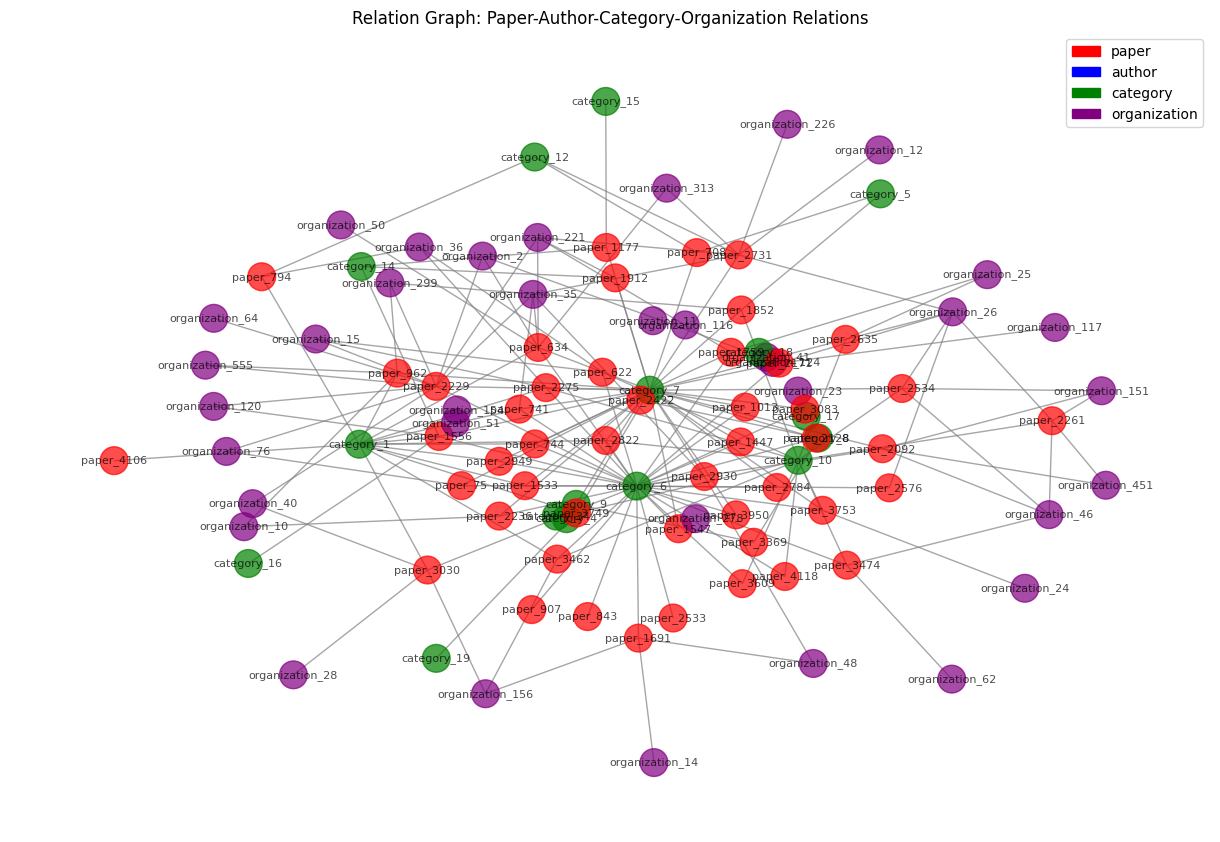

In [10]:
# Extract a subgraph of the most connected nodes for better visualization
largest_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:100]  # Top 50 most connected nodes
subgraph_nodes = [node for node, degree in largest_nodes]
subG = G.subgraph(subgraph_nodes)

# Assign colors to different node types
node_colors = {
    "paper": "red",
    "author": "blue",
    "category": "green",
    "organization": "purple"
}

# # Ensure all nodes have a type
# for node in G.nodes():
#     if "type" not in G.nodes[node]:
#         G.nodes[node]["type"] = "unknown"

colors = [node_colors.get(G.nodes[n]["type"], "gray") for n in subG.nodes()]

# Use a faster layout algorithm
pos = nx.kamada_kawai_layout(subG)

# Draw the subgraph
plt.figure(figsize=(12, 8))
nx.draw(
    subG, pos, with_labels=True, node_size=400, font_size=8,
    edge_color="gray", alpha=0.7, node_color=colors
)

# Create a legend
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in node_colors.items()]
plt.legend(handles=legend_patches, loc="upper right")
plt.title("Relation Graph: Paper-Author-Category-Organization Relations")
plt.show()

# 2. Network Structure
* Dense Central Core:

  * The middle of the graph has a high concentration of red (papers) and green (categories), indicating highly cited or interdisciplinary papers.
  * These papers are likely covering broad or influential research topics.

* Purple Nodes (Organizations) on the Periphery:

  * Organizations are more spread out and typically have fewer connections compared to papers and categories.
  * This suggests that each organization is primarily associated with specific sets of papers rather than spanning multiple domains.

* Green Nodes (Categories) Clustered Around Papers:

  * Some categories have multiple papers, forming small category-based clusters.
  * This suggests certain research topics have high activity and many contributions.

# 3. Key Insights
* Highly Connected Papers Indicate Influential Research:

  * Papers with many connections to authors, categories, and organizations might be highly referenced or collaborative works.
  * If we check degree centrality, these papers would likely rank highest.

* Authors Might Be Missing in This Graph:

  * If authors were included but are not visible, it could be due to:
    * Their lower degree centrality compared to papers and categories.
    * Being filtered out due to subgraph selection.
    * Layout algorithm positioning them in a way that overlaps or clusters them.

* Potential Collaborations Between Organizations:

  * If we analyze organization links, we may find institutions working on similar topics.

In [7]:
# Compute Graph Statistics
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
node_types = {node_type: sum(1 for _, attr in G.nodes(data=True) if attr["type"] == node_type) for node_type in ["paper", "author", "category", "organization"]}

print(f"Total Nodes: {num_nodes}")
print(f"Papers: {node_types['paper']}")
print(f"Authors: {node_types['author']}")
print(f"Categories: {node_types['category']}")
print(f"Organizations: {node_types['organization']}")
print(f"Total Edges (Relationships): {num_edges}")

Total Nodes: 26608
Papers: 4193
Authors: 18522
Categories: 224
Organizations: 3669
Total Edges (Relationships): 47054


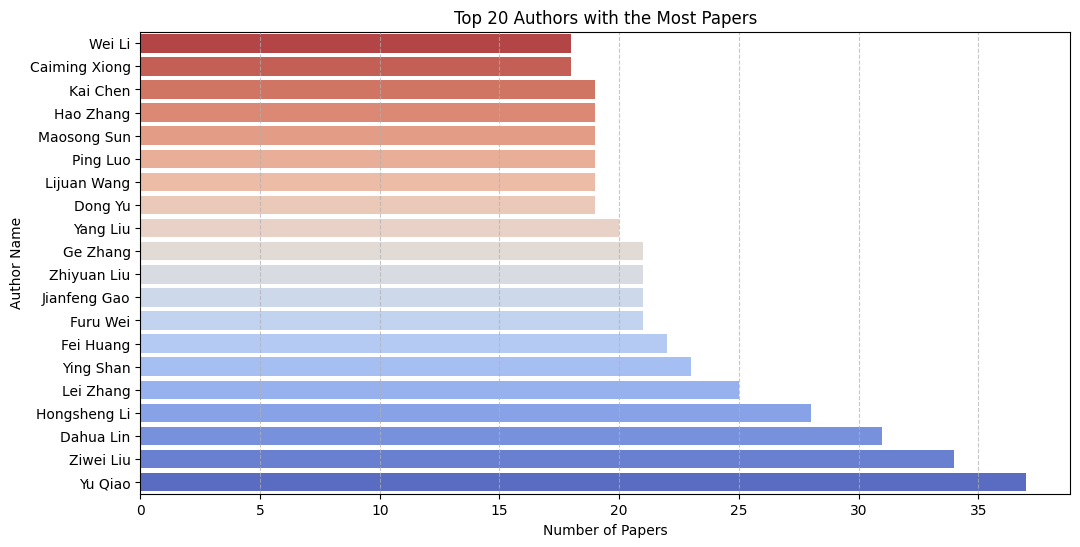

In [17]:
# Step 1: Find Top 20 Authors with the Most Papers
author_paper_count = {}
for _, row in dataframes["paper_author"].iterrows():
    author_paper_count[row["author_id"]] = author_paper_count.get(row["author_id"], 0) + 1

top_authors = sorted(author_paper_count.items(), key=lambda x: x[1], reverse=True)[:20]

author_names = {row["node_id"]: row["name"] for _, row in dataframes["author"].iterrows()}
author_labels = [author_names.get(author[0], author[0]) for author in top_authors]

plt.figure(figsize=(12, 6))
sns.barplot(y=author_labels, x=[author[1] for author in top_authors], palette="coolwarm")
plt.xlabel("Number of Papers")
plt.ylabel("Author Name")
plt.title("Top 20 Authors with the Most Papers")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

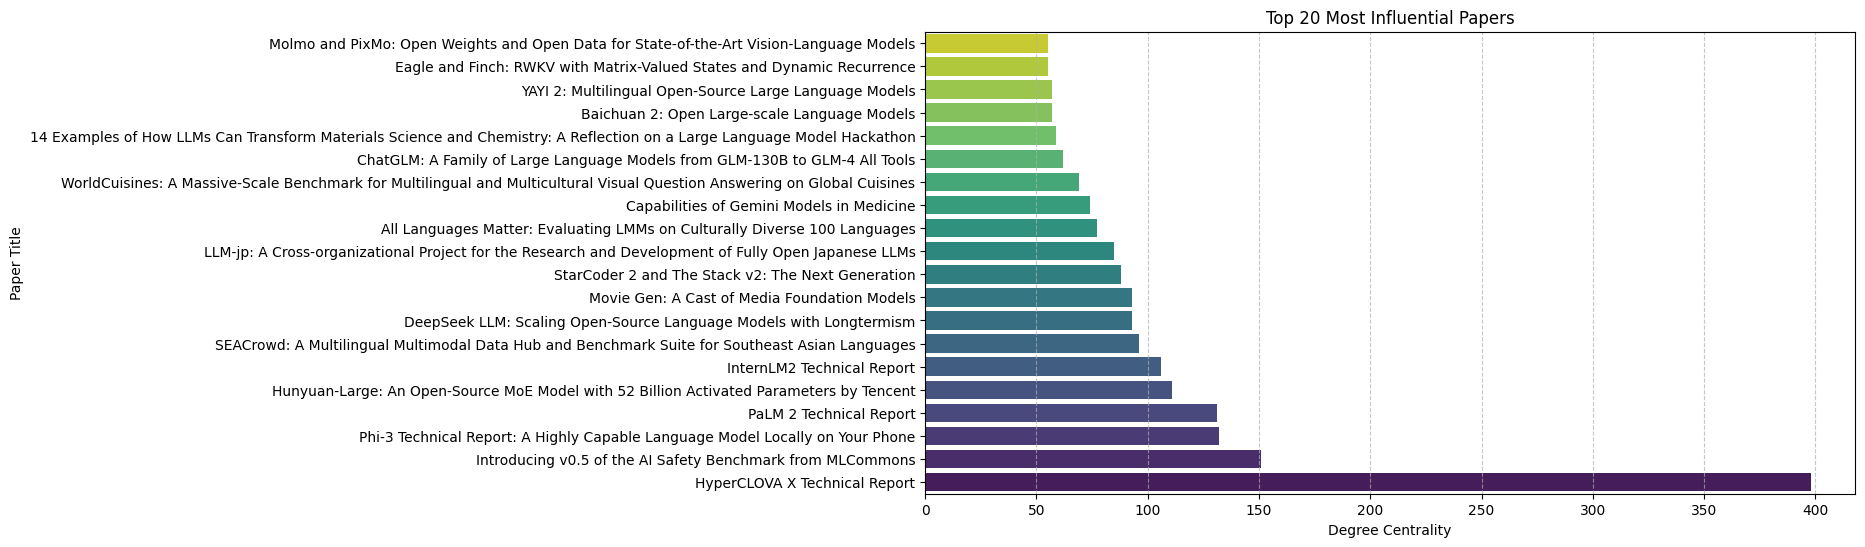

In [18]:
# Step 2: Find Top 20 Most Influential Papers (Highest Degree Centrality)
paper_centrality = {node: G.degree(node) for node, attr in G.nodes(data=True) if attr["type"] == "paper"}
top_papers = sorted(paper_centrality.items(), key=lambda x: x[1], reverse=True)[:20]

paper_labels = [paper_titles.get(paper[0], paper[0]) for paper in top_papers]

plt.figure(figsize=(12, 6))
sns.barplot(y=paper_labels, x=[paper[1] for paper in top_papers], palette="viridis")
plt.xlabel("Degree Centrality")
plt.ylabel("Paper Title")
plt.title("Top 20 Most Influential Papers")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

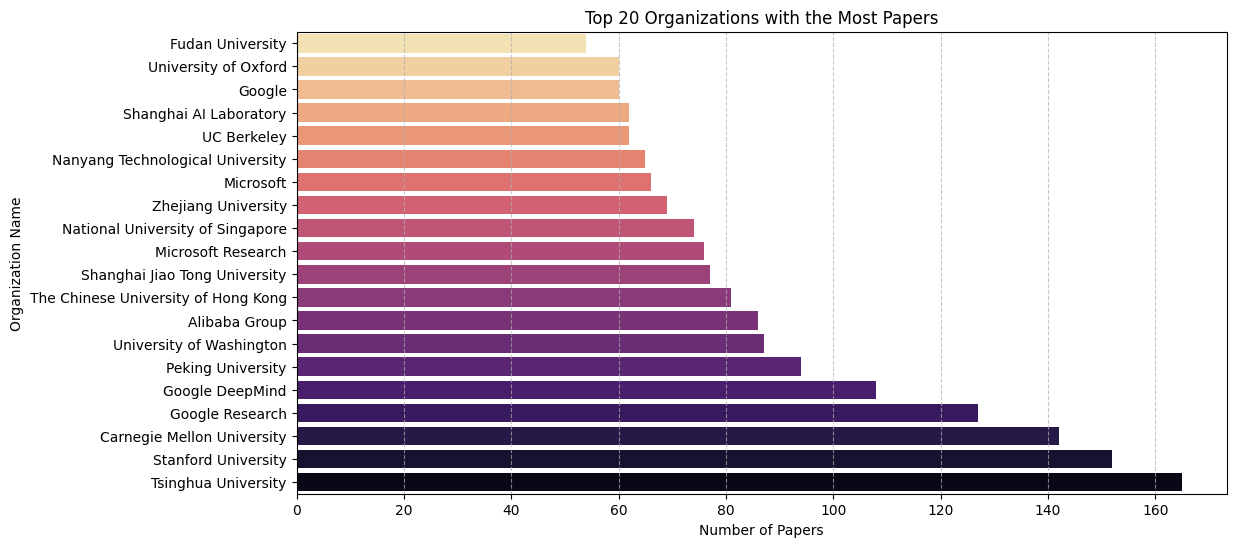

In [19]:
# Step 3: Find Top 20 Organizations with the Most Papers
organization_paper_count = {}
for paper, org in dataframes["paper_organization"].itertuples(index=False):
    organization_paper_count[org] = organization_paper_count.get(org, 0) + 1

top_organizations = sorted(organization_paper_count.items(), key=lambda x: x[1], reverse=True)[:20]
organization_labels = [organization_names.get(org[0], org[0]) for org in top_organizations]

plt.figure(figsize=(12, 6))
sns.barplot(y=organization_labels, x=[org[1] for org in top_organizations], palette="magma")
plt.xlabel("Number of Papers")
plt.ylabel("Organization Name")
plt.title("Top 20 Organizations with the Most Papers")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

Checking connection between Paper and author to see why there is no connction in main graph :

In [8]:
# Create a new graph for paper-author relationships
G_author_paper = nx.Graph()

# Extract author names
author_names = {row["node_id"]: row["name"] for _, row in dataframes["author"].iterrows()}

# Add paper nodes
for _, row in dataframes["paper"].iterrows():
    G_author_paper.add_node(row["node_id"], type="paper", label=row["title"])

# Add author nodes and connections
for _, row in dataframes["paper_author"].iterrows():
    G_author_paper.add_node(row["author_id"], type="author", label=author_names.get(row["author_id"], row["author_id"]))
    G_author_paper.add_edge(row["paper_id"], row["author_id"], relation="authored")

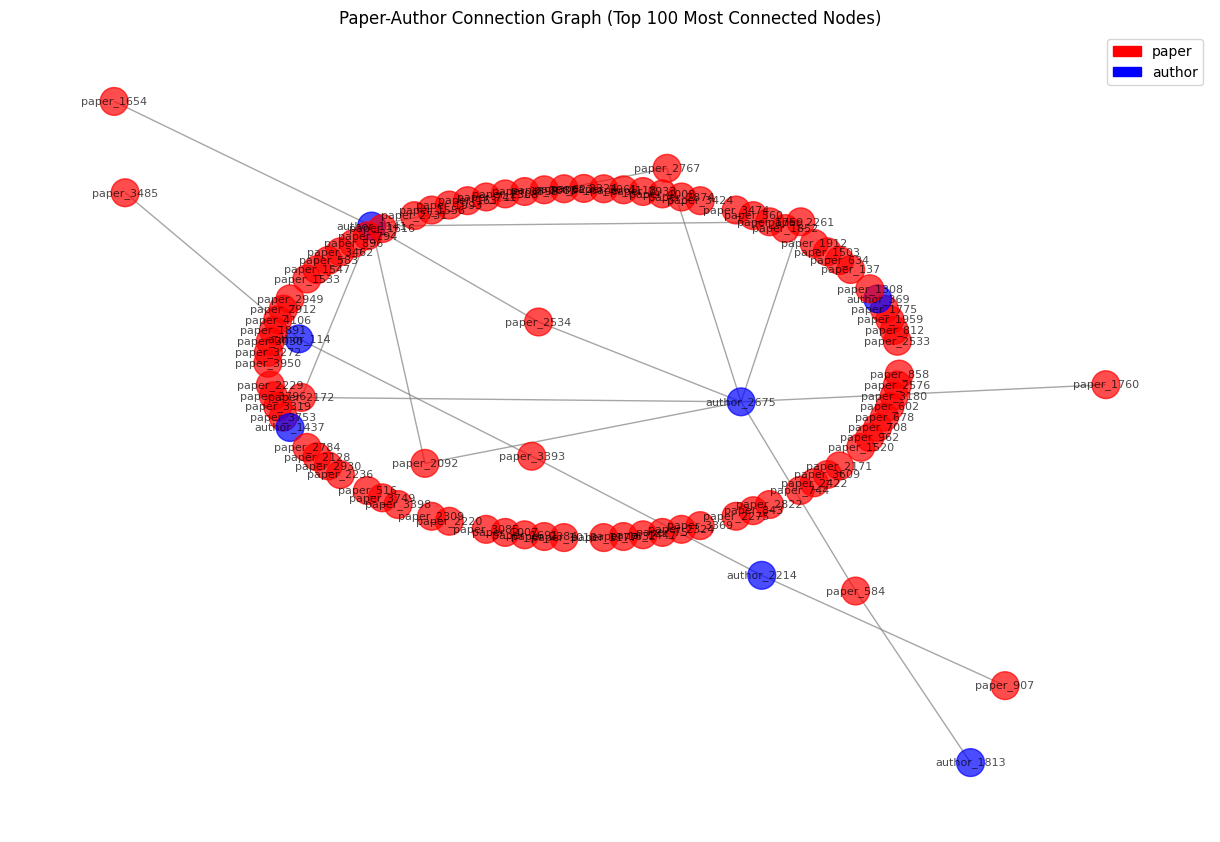

In [9]:
# Extract a subgraph of the most connected nodes for better visualization
largest_nodes = sorted(G_author_paper.degree, key=lambda x: x[1], reverse=True)[:100]  # Top 100 most connected nodes
subgraph_nodes = [node for node, degree in largest_nodes]
subG = G_author_paper.subgraph(subgraph_nodes)

# Assign colors to different node types
node_colors = {
    "paper": "red",
    "author": "blue",
}

# Extract colors for subgraph nodes
sub_colors = [node_colors[subG.nodes[n]["type"]] for n in subG.nodes()]

# Use a layout algorithm
pos = nx.kamada_kawai_layout(subG)

# Draw the subgraph
plt.figure(figsize=(12, 8))
nx.draw(
    subG, pos, with_labels=True, node_size=400, font_size=8,
    edge_color="gray", alpha=0.7, node_color=sub_colors
)

# Create a legend
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in node_colors.items()]
plt.legend(handles=legend_patches, loc="upper right")
plt.title("Paper-Author Connection Graph (Top 100 Most Connected Nodes)")
plt.show()

# centrality measures

1. Degree Centrality : How many direct connections (edges) a node has.
2. Betweenness Centrality : How often a node appears on the shortest path between other nodes.
3. Closeness Centrality : How easily a node can reach other nodes in the network.
4. Eigenvector Centrality : Influence of a node based on its connections to other important nodes.
5. PageRank Centrality : Importance of a node considering both its connections and the importance of those connections.

In [12]:
# Function to compute and store each centrality measure in a structured JSON format
def save_centrality_measure(measure_name, compute_function, G):
    file_path = f"{measure_name.lower()}.json"
    if not os.path.exists(file_path):  # Avoid recomputation if already exists
        print(f"Computing {measure_name} centrality...")
        centrality = compute_function(G)
        structured_data = {
            "measure": measure_name,
            "description": f"{measure_name} centrality values for nodes",
            "data": centrality
        }
        with open(file_path, "w") as f:
            json.dump(structured_data, f, indent=4)
        print(f"{measure_name} centrality saved to {file_path}")
    else:
        print(f"{measure_name} centrality already exists, skipping computation.")

# Compute and save each centrality measure separately with metadata
save_centrality_measure("degree", nx.degree_centrality, G)
save_centrality_measure("betweenness", nx.betweenness_centrality, G)
save_centrality_measure("closeness", nx.closeness_centrality, G)
save_centrality_measure("eigenvector", lambda G: nx.eigenvector_centrality(G, max_iter=500), G)
save_centrality_measure("pagerank", nx.pagerank, G)

print("All centrality measures computed and stored separately in structured JSON files.")

Computing degree centrality...
degree centrality saved to degree.json
Computing betweenness centrality...
betweenness centrality saved to betweenness.json
Computing closeness centrality...
closeness centrality saved to closeness.json
Computing eigenvector centrality...
eigenvector centrality saved to eigenvector.json
Computing pagerank centrality...
pagerank centrality saved to pagerank.json
All centrality measures computed and stored separately in structured JSON files.


# Interpretation

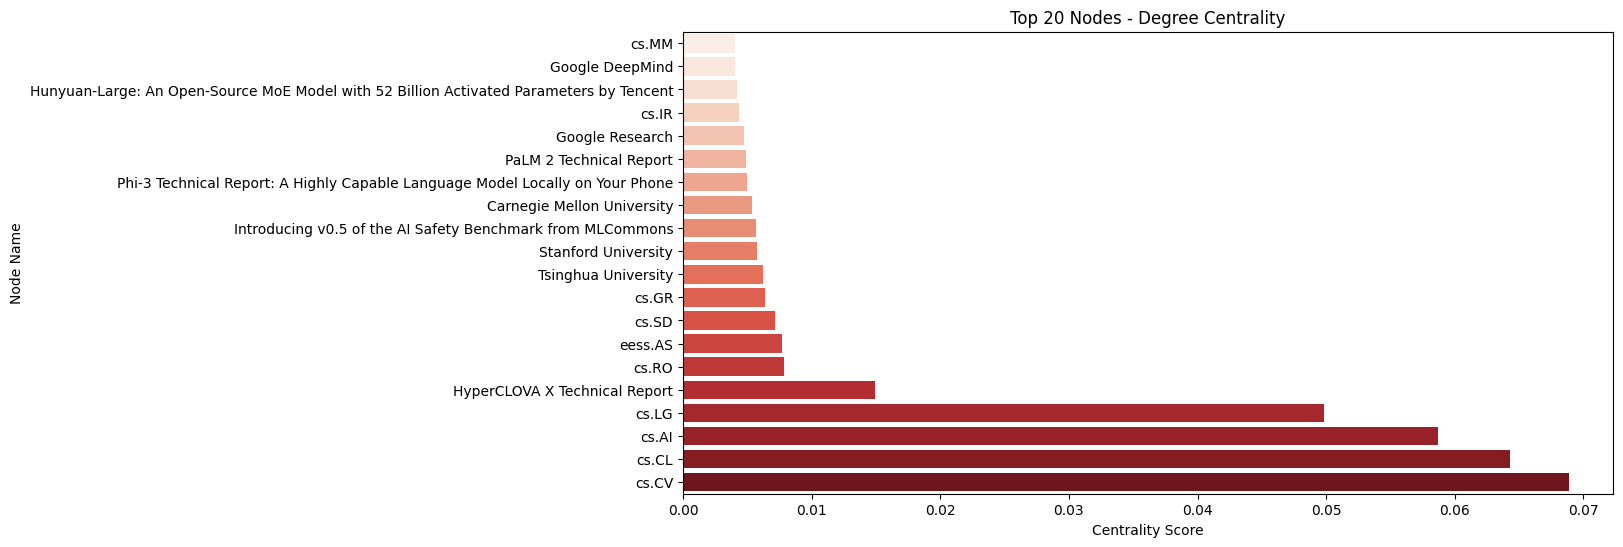

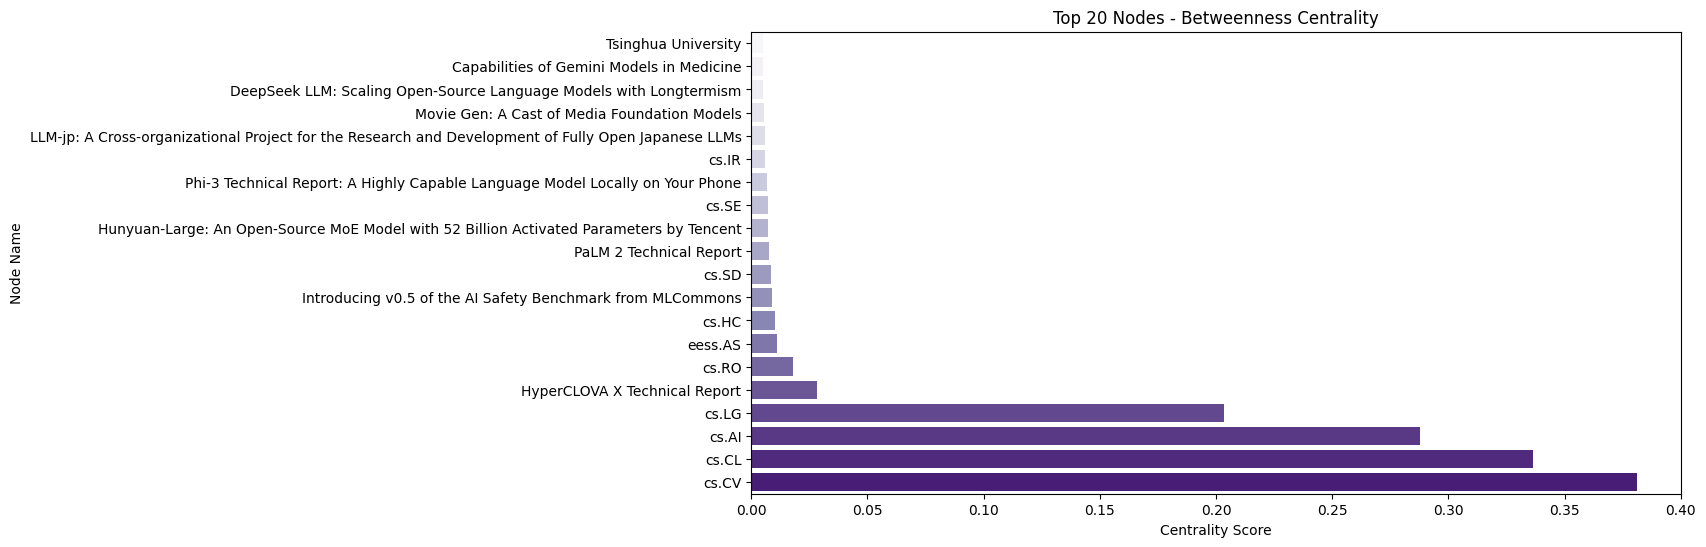

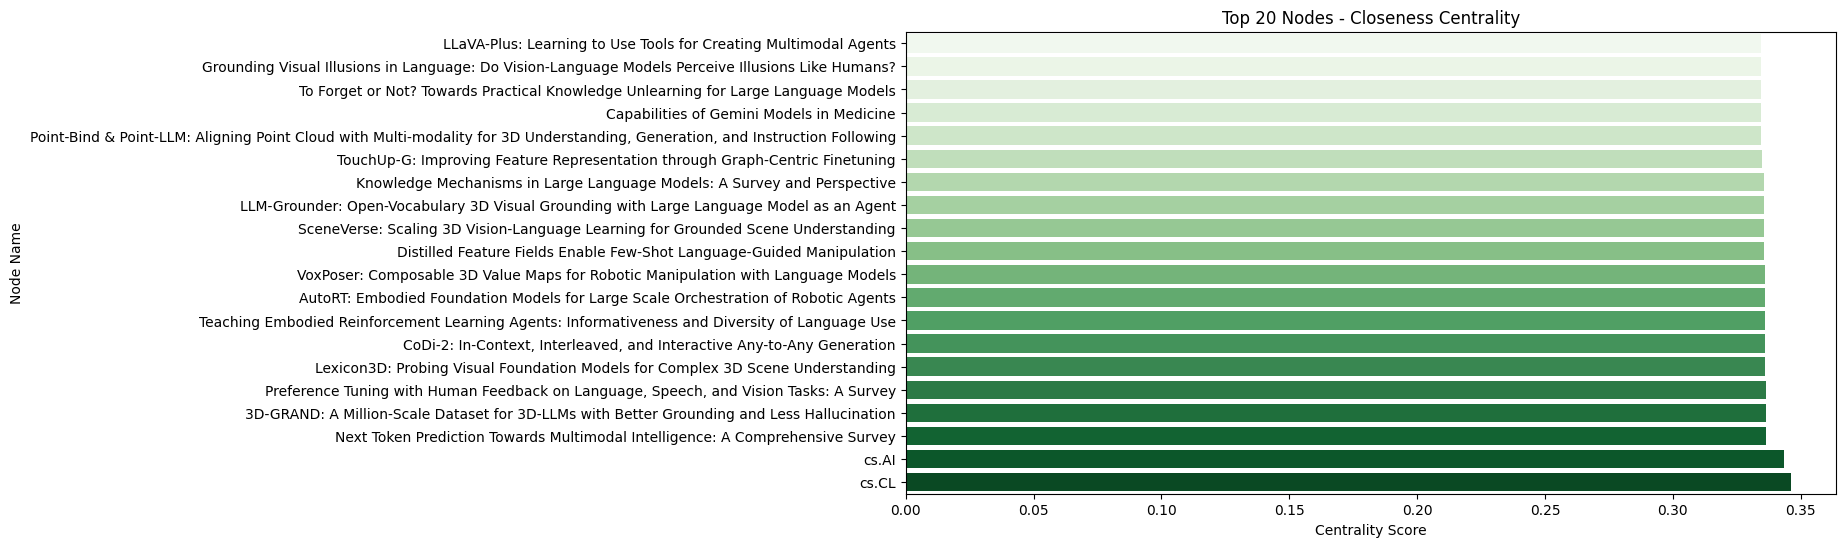

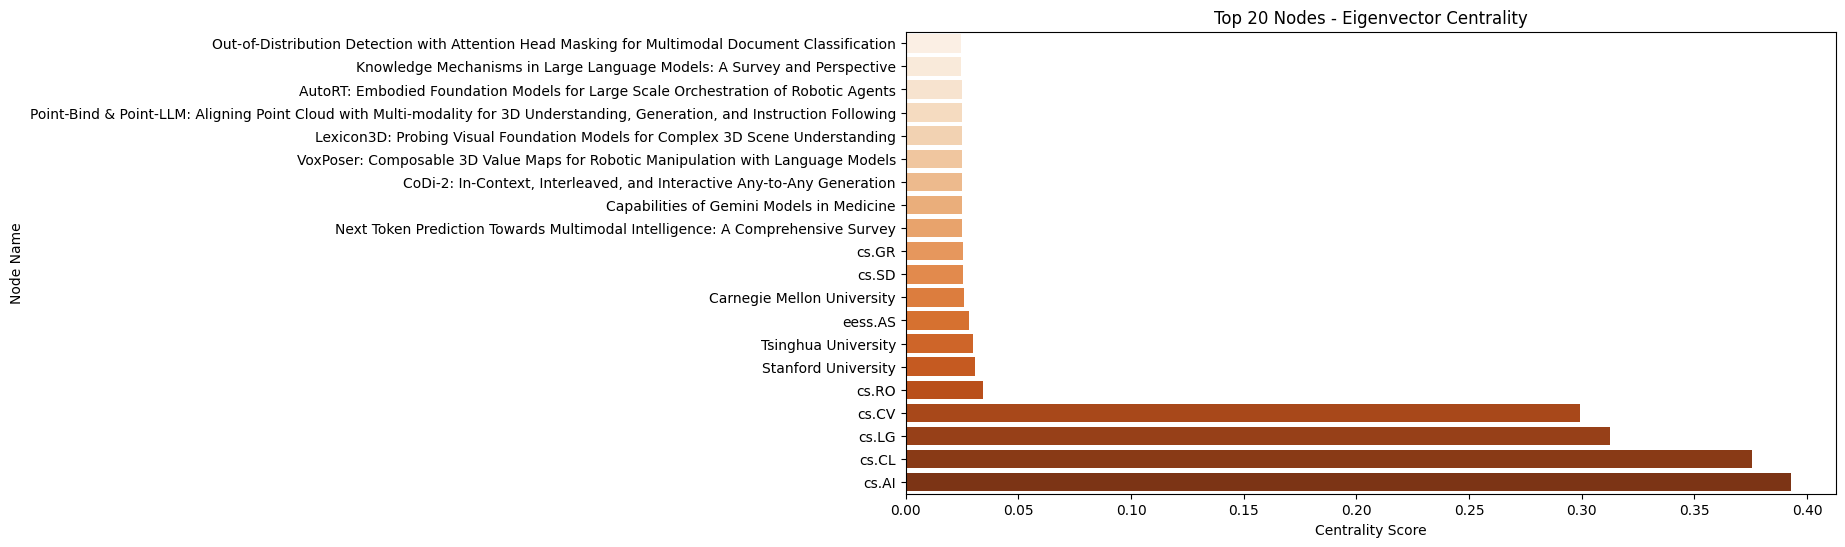

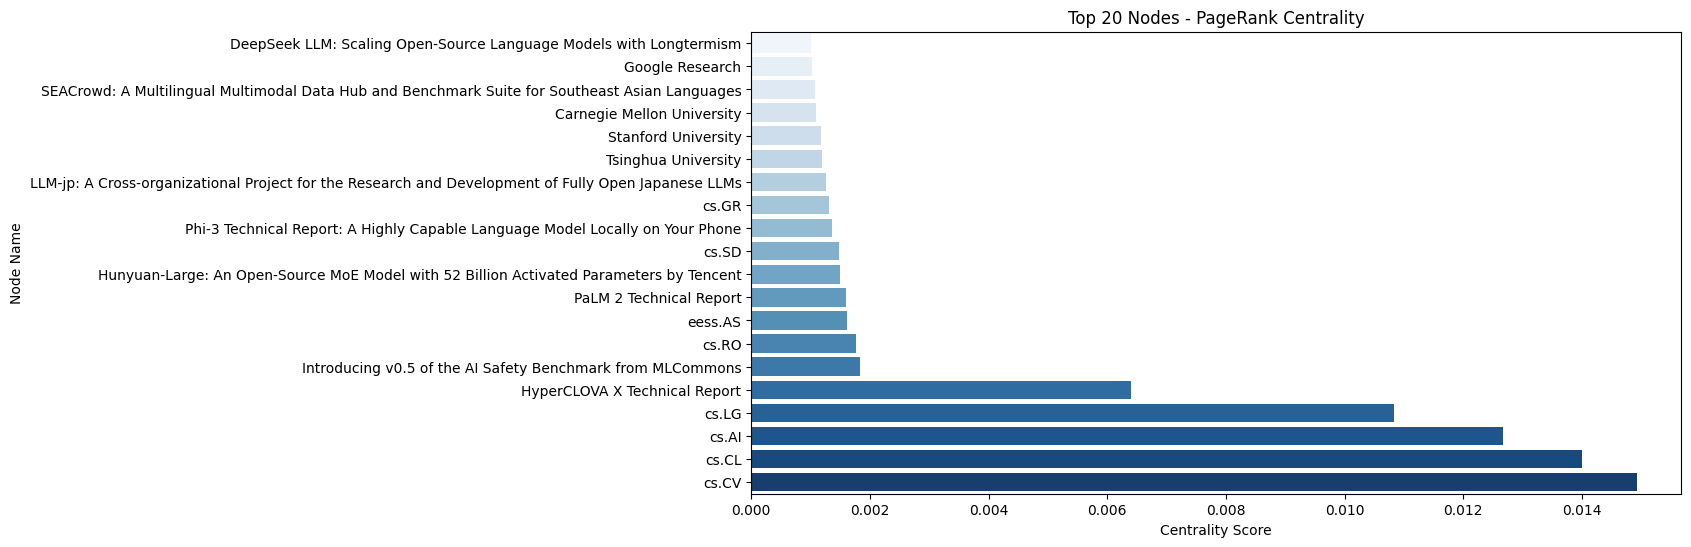

In [26]:
# Load all necessary datasets
paper_df = pd.read_csv("/content/drive/MyDrive/daily-papers-analysis-main/GraphDataset/paper.csv")
category_df = pd.read_csv("/content/drive/MyDrive/daily-papers-analysis-main/GraphDataset/category.csv")
organization_df = pd.read_csv("/content/drive/MyDrive/daily-papers-analysis-main/GraphDataset/organization.csv")
author_df = pd.read_csv("/content/drive/MyDrive/daily-papers-analysis-main/GraphDataset/author.csv")

# Create mappings from node IDs to their real names
paper_mapping = {row["node_id"]: row["title"] for _, row in paper_df.iterrows()}
category_mapping = {row["node_id"]: row["name"] for _, row in category_df.iterrows()}
organization_mapping = {row["node_id"]: row["name"] for _, row in organization_df.iterrows()}
author_mapping = {row["node_id"]: row["name"] for _, row in author_df.iterrows()}

# Merge all mappings
node_name_mapping = {**paper_mapping, **category_mapping, **organization_mapping}

# File paths for the uploaded JSON files
centrality_files = {
    "Degree": "/content/degree.json",
    "Betweenness": "/content/betweenness.json",
    "Closeness": "/content/closeness.json",
    "Eigenvector": "/content/eigenvector.json",
    "PageRank": "/content/pagerank.json",
}

# Load centrality data
centrality_data = {}
for name, file_path in centrality_files.items():
    with open(file_path, "r") as f:
        centrality_data[name] = json.load(f)["data"]

# Extract top 20 nodes for each centrality measure
top_centrality = {}
for measure, data in centrality_data.items():
    sorted_nodes = sorted(data.items(), key=lambda x: x[1], reverse=True)[:20]
    top_centrality[measure] = [(node_name_mapping.get(node, node), value) for node, value in sorted_nodes]

# Define color palettes for variety
color_palettes = {
    "Degree": "Reds_r",
    "Betweenness": "Purples_r",
    "Closeness": "Greens_r",
    "Eigenvector": "Oranges_r",
    "PageRank": "Blues_r",
}

# Iterate through centrality measures and plot each separately
for measure, data in top_centrality.items():
    plt.figure(figsize=(12, 6))
    node_ids, values = zip(*data)
    sns.barplot(y=list(node_ids), x=list(values), palette=color_palettes.get(measure, "coolwarm"))
    plt.xlabel("Centrality Score")
    plt.ylabel("Node Name")
    plt.title(f"Top 20 Nodes - {measure} Centrality")
    plt.gca().invert_yaxis()
    plt.show()

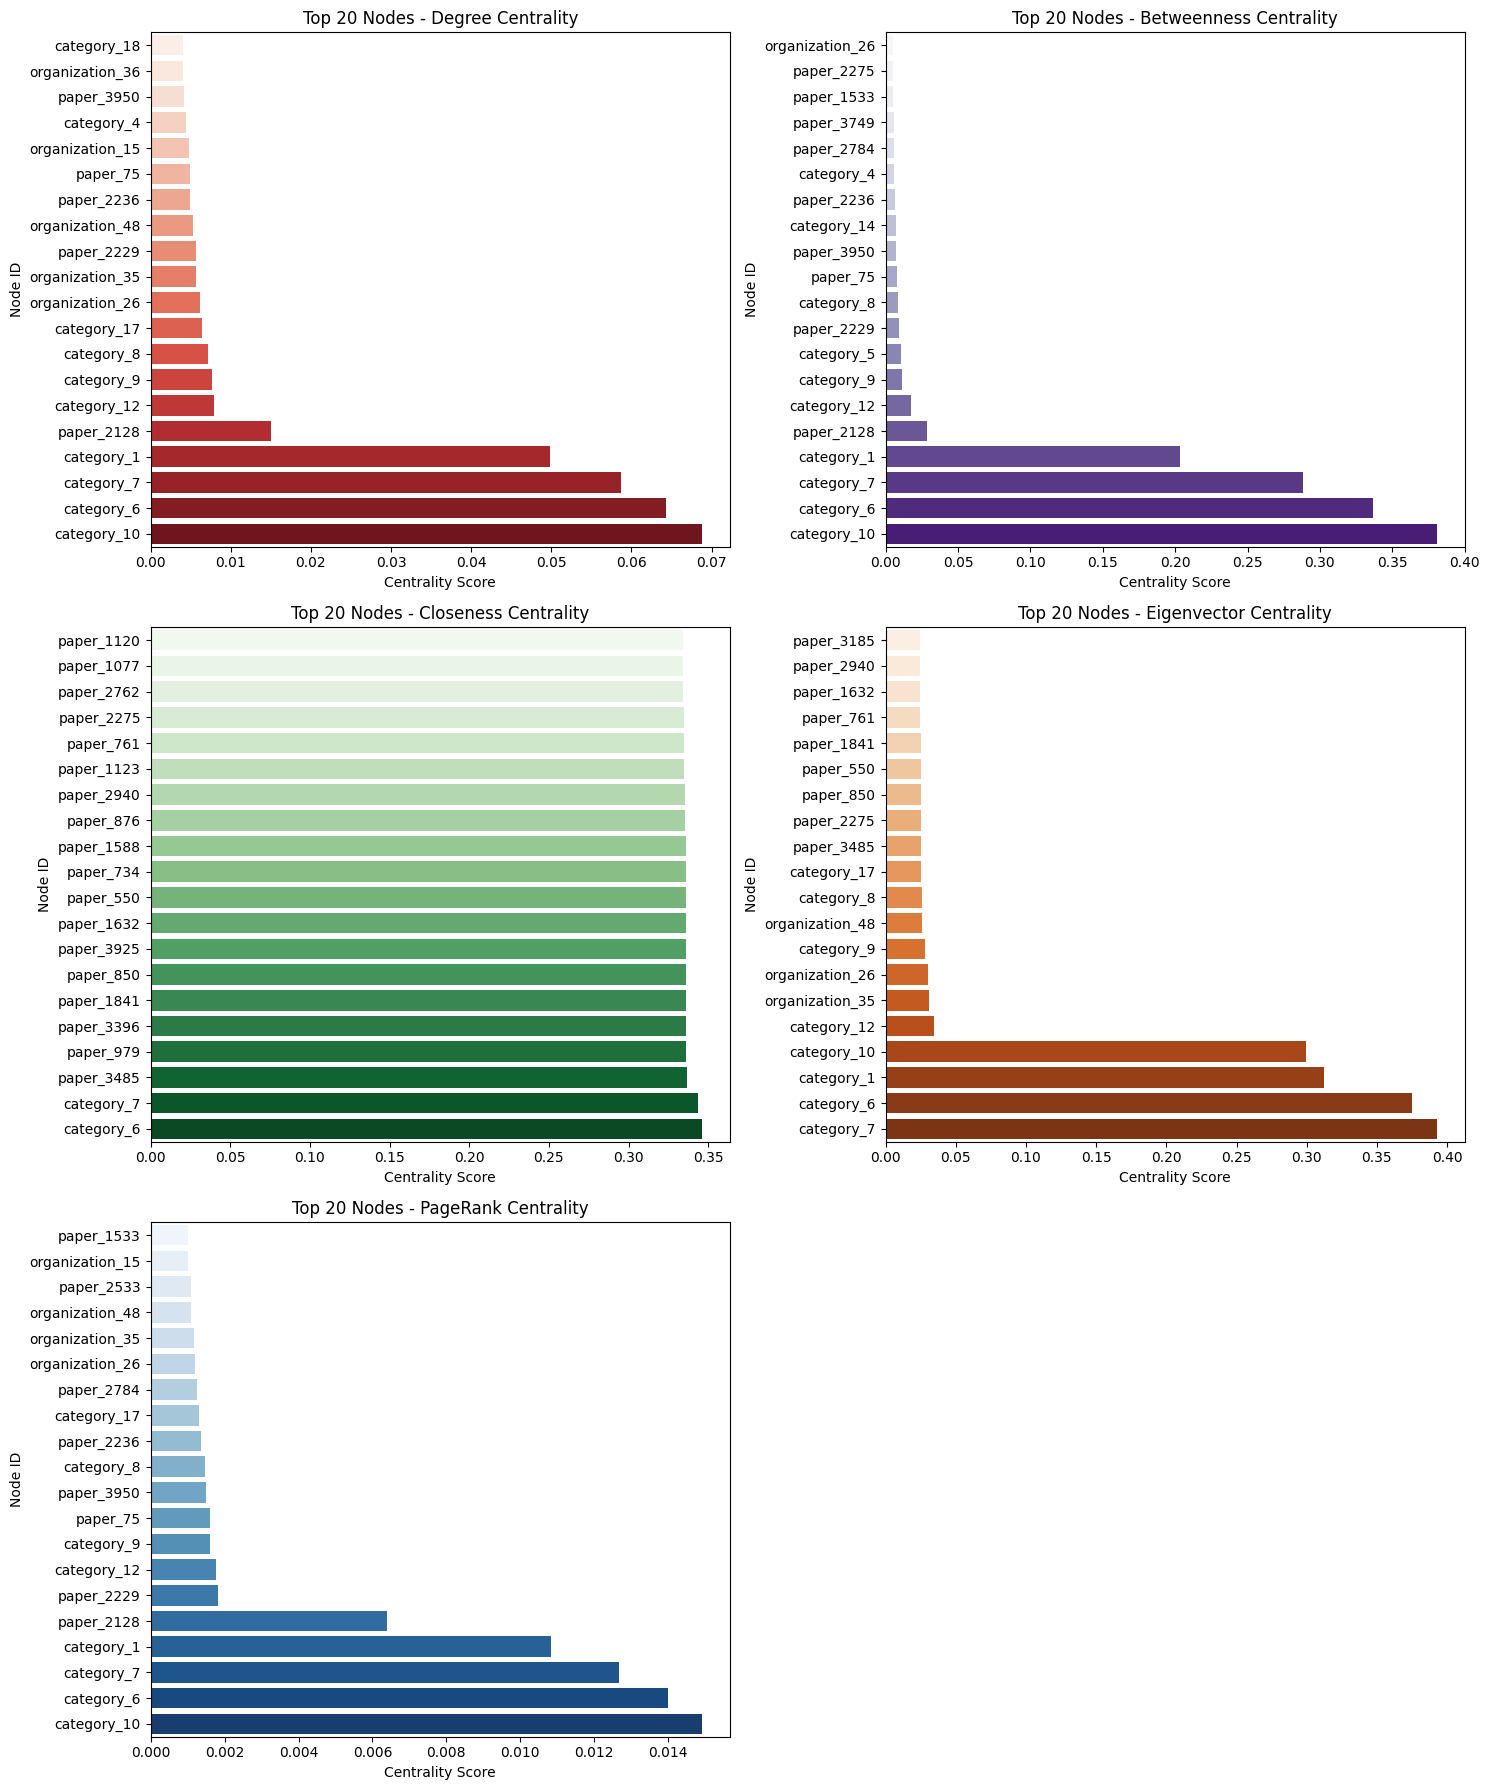

In [19]:
# File paths for the uploaded JSON files
centrality_files = {
    "Degree": "/content/degree.json",
    "Betweenness": "/content/betweenness.json",
    "Closeness": "/content/closeness.json",
    "Eigenvector": "/content/eigenvector.json",
    "PageRank": "/content/pagerank.json",
}

# Load centrality data
centrality_data = {}
for name, file_path in centrality_files.items():
    with open(file_path, "r") as f:
        centrality_data[name] = json.load(f)["data"]

# Extract top 20 nodes for each centrality measure
top_centrality = {}
for measure, data in centrality_data.items():
    sorted_nodes = sorted(data.items(), key=lambda x: x[1], reverse=True)[:20]
    top_centrality[measure] = sorted_nodes

# Plot all centrality measures in subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 18))  # 3 rows, 2 columns layout
axes = axes.flatten()

# Define color palettes for variety
color_palettes = {
    "Degree": "Reds_r",
    "Betweenness": "Purples_r",
    "Closeness": "Greens_r",
    "Eigenvector": "Oranges_r",
    "PageRank": "Blues_r",
}

# Iterate through centrality measures and plot them
for idx, (measure, data) in enumerate(top_centrality.items()):
    node_ids, values = zip(*data)
    sns.barplot(y=list(node_ids), x=list(values), palette=color_palettes.get(measure, "coolwarm"), ax=axes[idx])
    axes[idx].set_xlabel("Centrality Score")
    axes[idx].set_ylabel("Node ID")
    axes[idx].set_title(f"Top 20 Nodes - {measure} Centrality")
    axes[idx].invert_yaxis()

# Hide any extra subplot if odd number of measures
if len(top_centrality) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

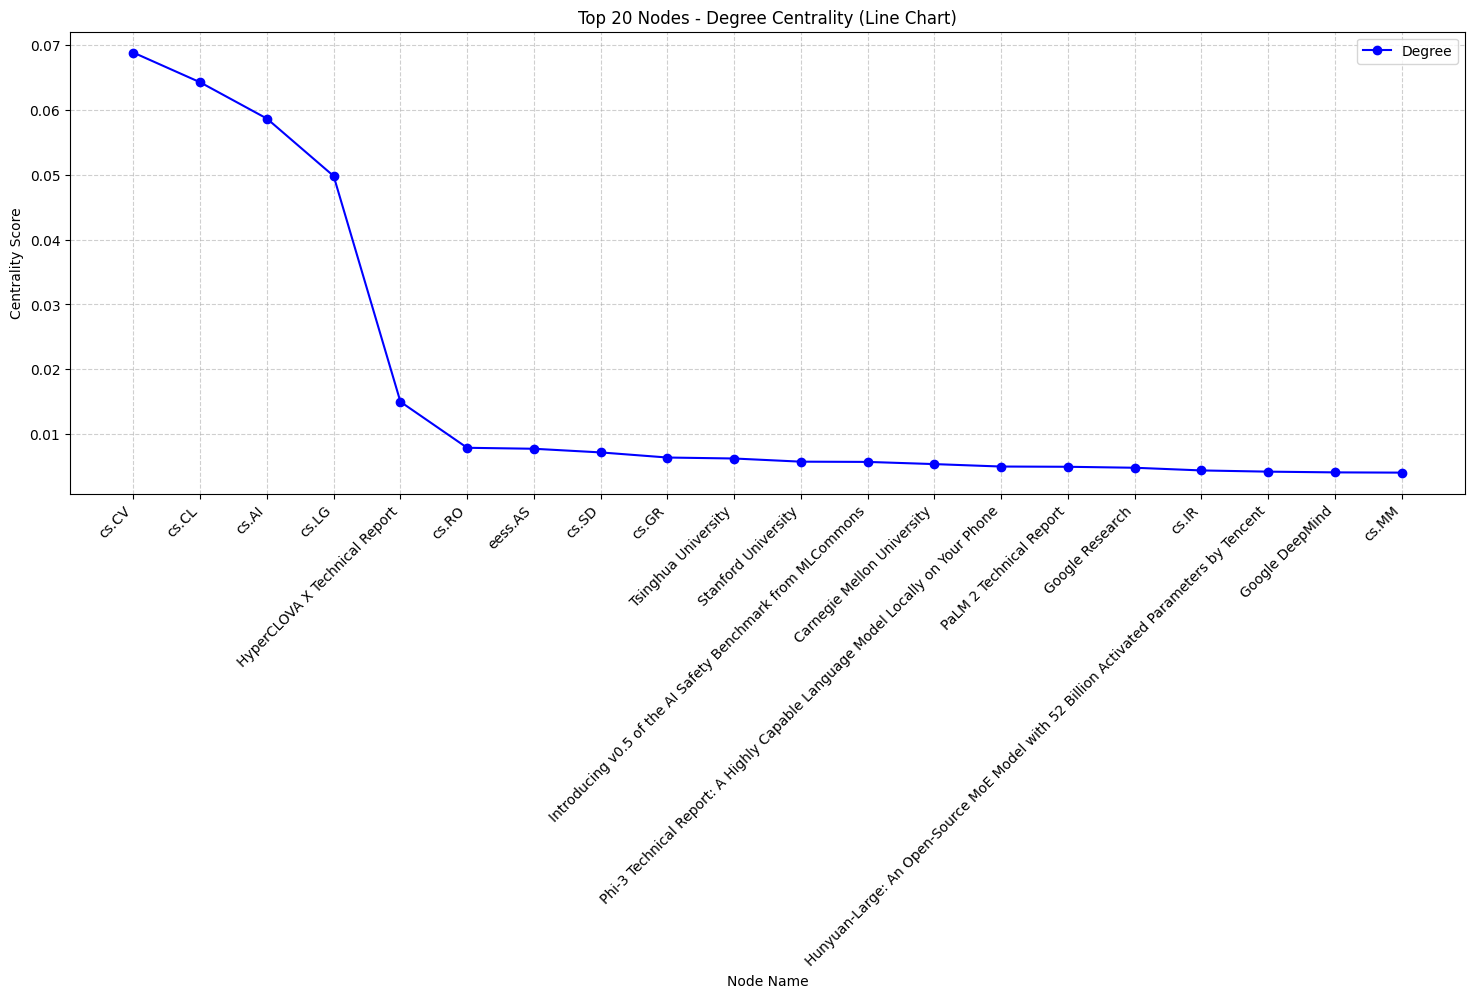

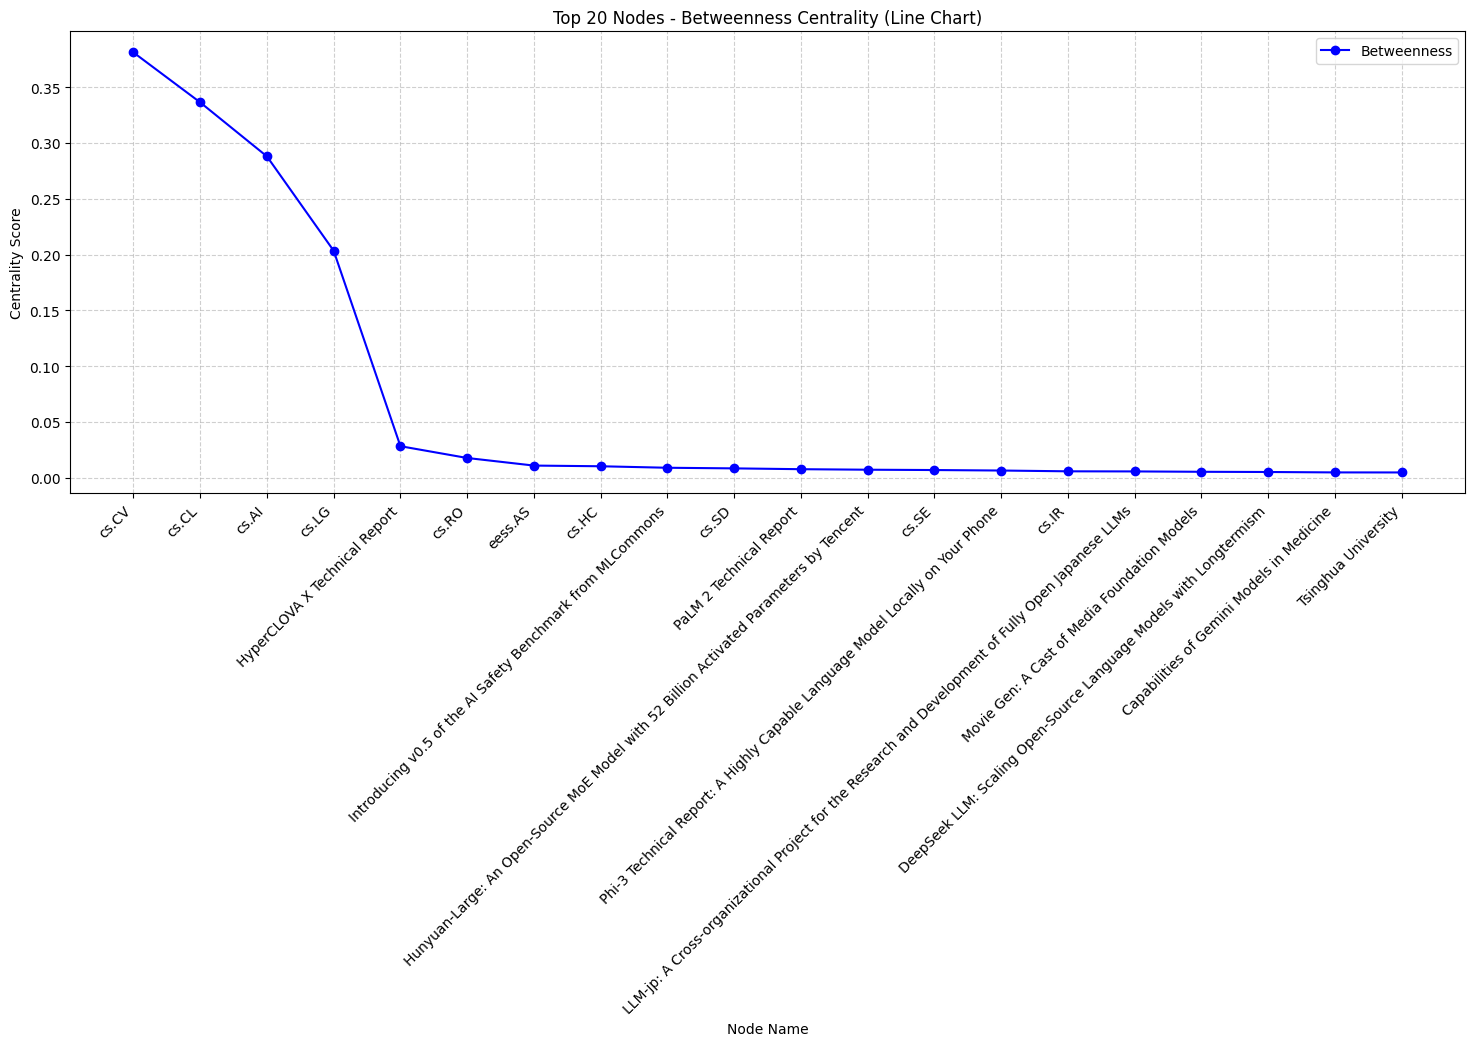

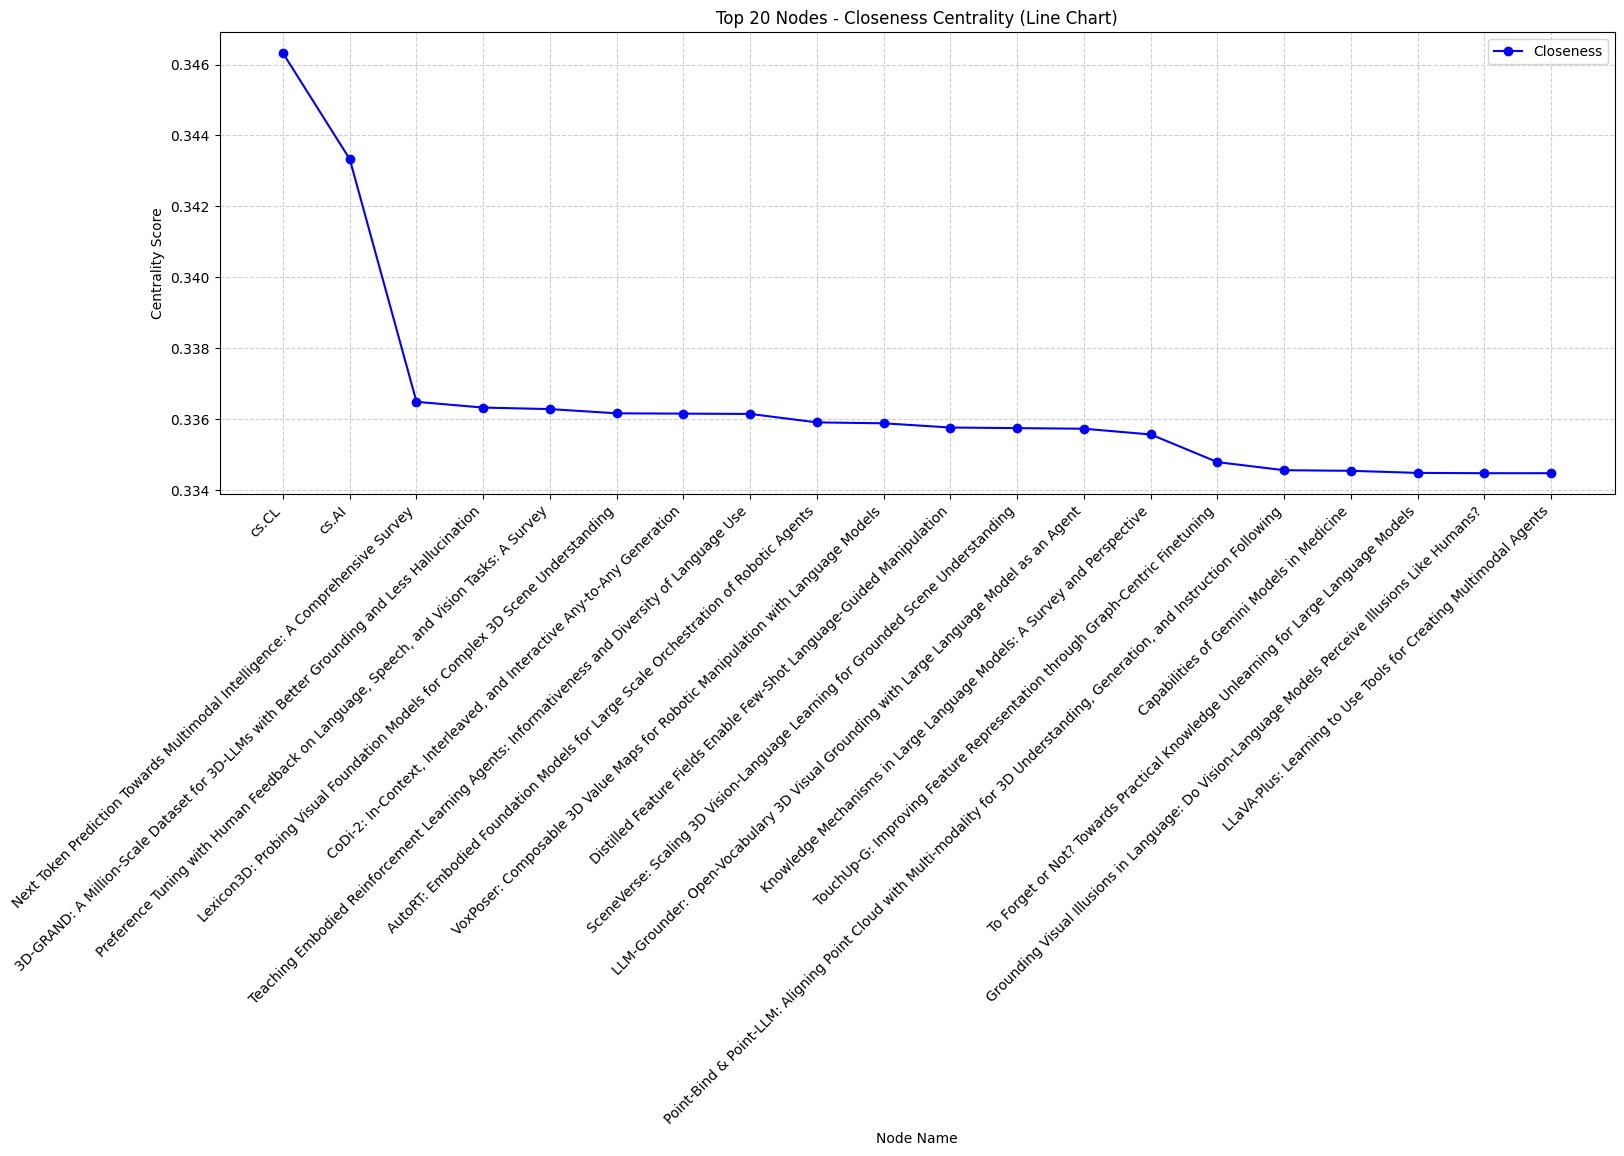

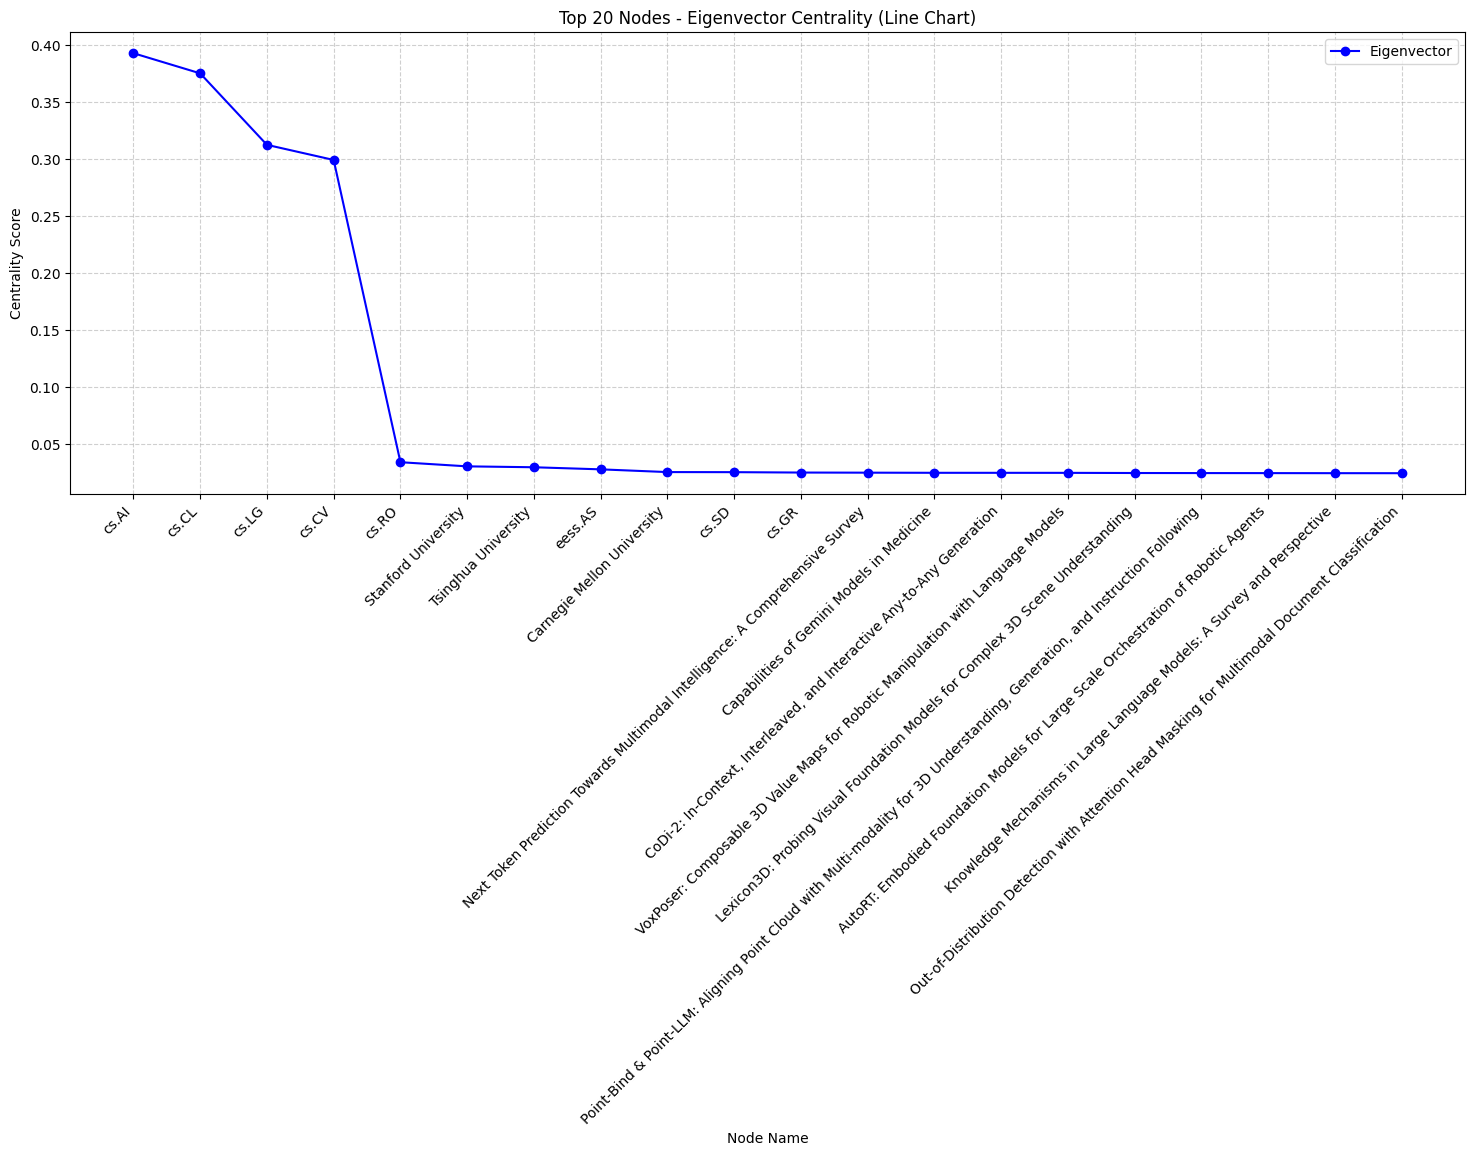

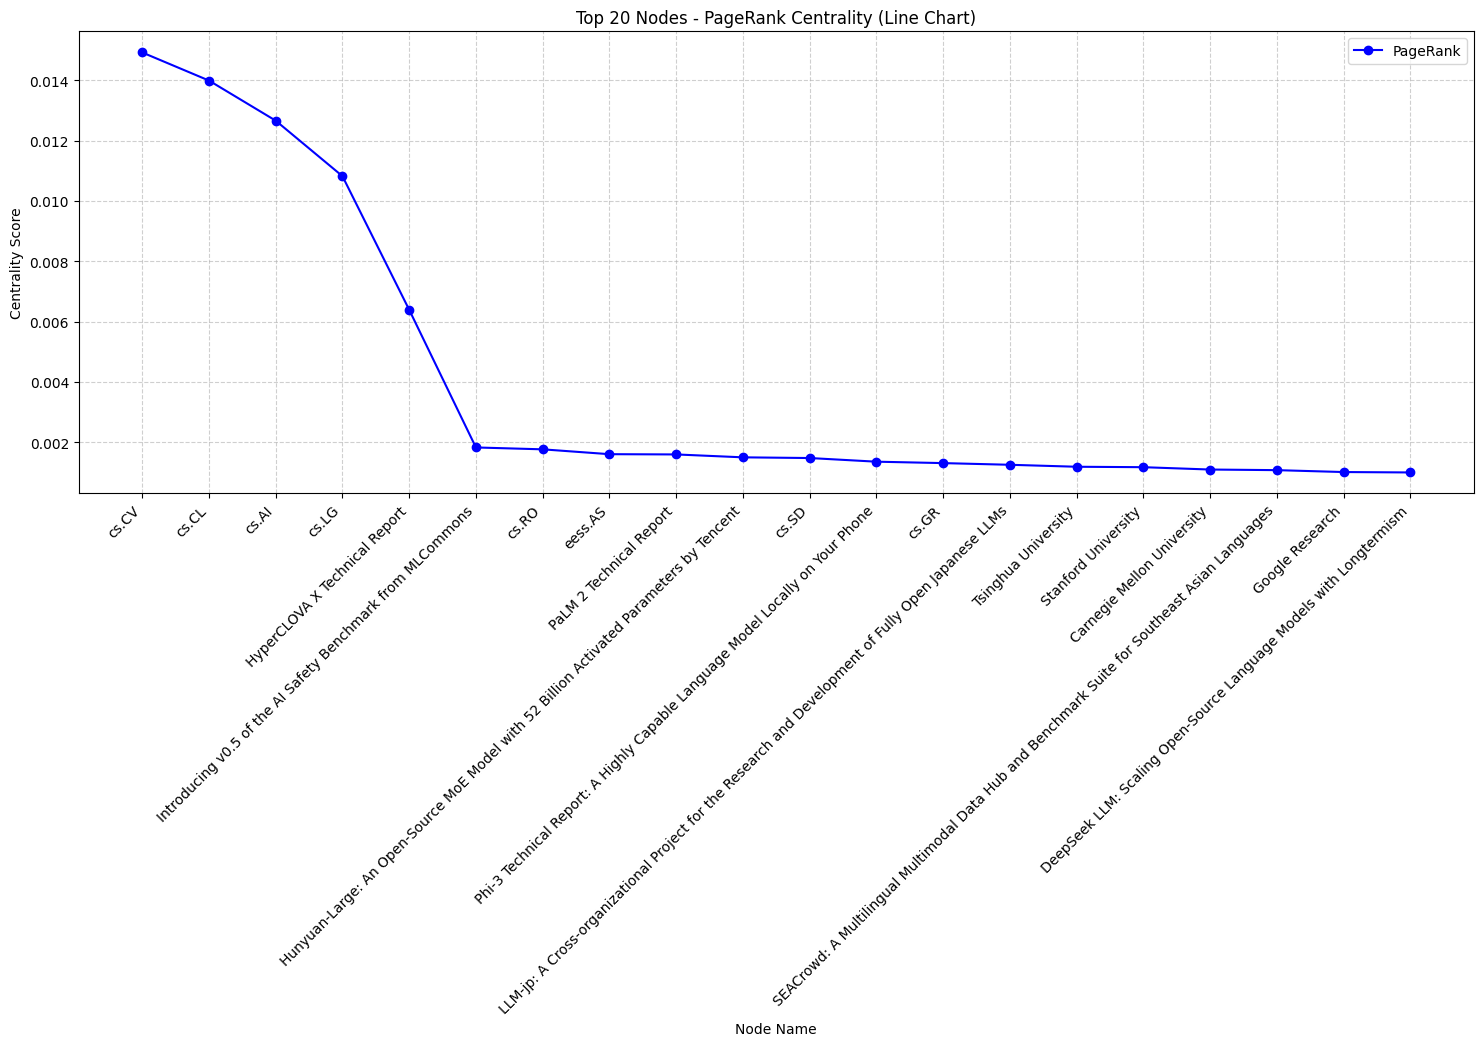

In [21]:
# Iterate through centrality measures and plot each separately as line charts
for measure, data in top_centrality.items():
    plt.figure(figsize=(18, 6))
    node_ids, values = zip(*data)
    plt.plot(range(len(node_ids)), values, marker='o', linestyle='-', color='b', label=measure)
    plt.xticks(range(len(node_ids)), node_ids, rotation=45, ha='right')
    plt.xlabel("Node Name")
    plt.ylabel("Centrality Score")
    plt.title(f"Top 20 Nodes - {measure} Centrality (Line Chart)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Key Insights
1. Research Areas Matter:

* "cs.CV" (Computer Vision), "cs.CL" (Computational Linguistics), and "cs.AI" (Artificial Intelligence) are the most central fields, meaning they are widely connected across the research landscape.
* This suggests that modern AI-related topics are the most referenced and influential.

2. Few Papers Dominate Influence:

* Papers like "HyperCLOVA X Technical Report" and "Hunyuan-Large" have very high PageRank scores, meaning they are key references or widely discussed in the research community.

3. Institutions with High Influence:

* Stanford University, Carnegie Mellon University, and Google Research appear in the rankings, showing they are among the most central organizations in AI research.

# what can do next ?

* Compare this with another centrality measure? (e.g., Degree, Betweenness)

* Focus on a specific type of node? (e.g., Only papers, Only organizations)

Top 5 Largest Research Communities: [(1, 26556), (2, 16), (3, 13), (4, 11), (5, 4)]


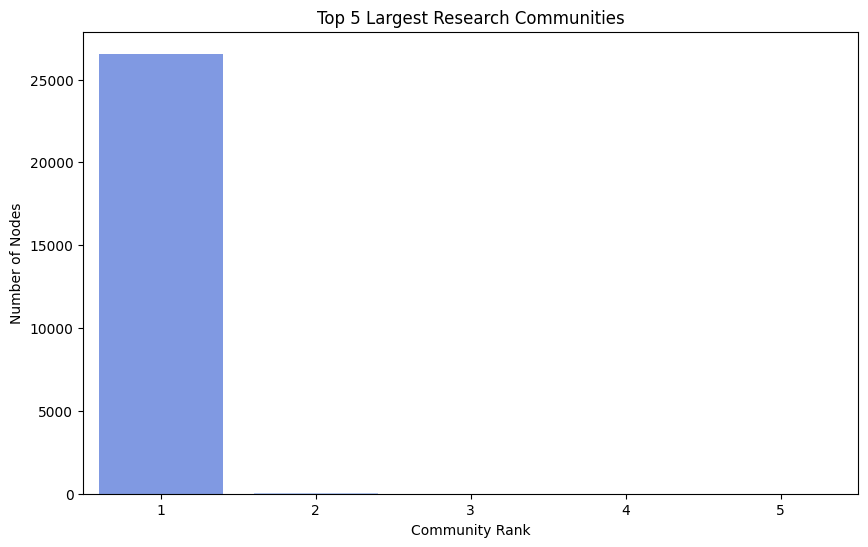

In [27]:
# Merge all mappings
node_name_mapping = {**paper_mapping, **category_mapping, **organization_mapping, **author_mapping}

# Step 3: Detect Largest Research Communities
largest_components = sorted(nx.connected_components(G), key=len, reverse=True)[:5]
top_communities = [(i+1, len(component)) for i, component in enumerate(largest_components)]
print("Top 5 Largest Research Communities:", top_communities)

# Plot Largest Research Communities
plt.figure(figsize=(10, 6))
community_labels, community_sizes = zip(*top_communities)
sns.barplot(x=list(community_labels), y=list(community_sizes), palette="coolwarm")
plt.xlabel("Community Rank")
plt.ylabel("Number of Nodes")
plt.title("Top 5 Largest Research Communities")
plt.show()

# Possible Reasons for This Structure
1. Strong centralization:
* A few key institutions, authors, or research topics act as hubs, connecting a vast majority of the network.

2. Disconnected small clusters:
* Some papers, authors, or institutions do not interact with the main network, likely because they are from niche research areas or newer fields.

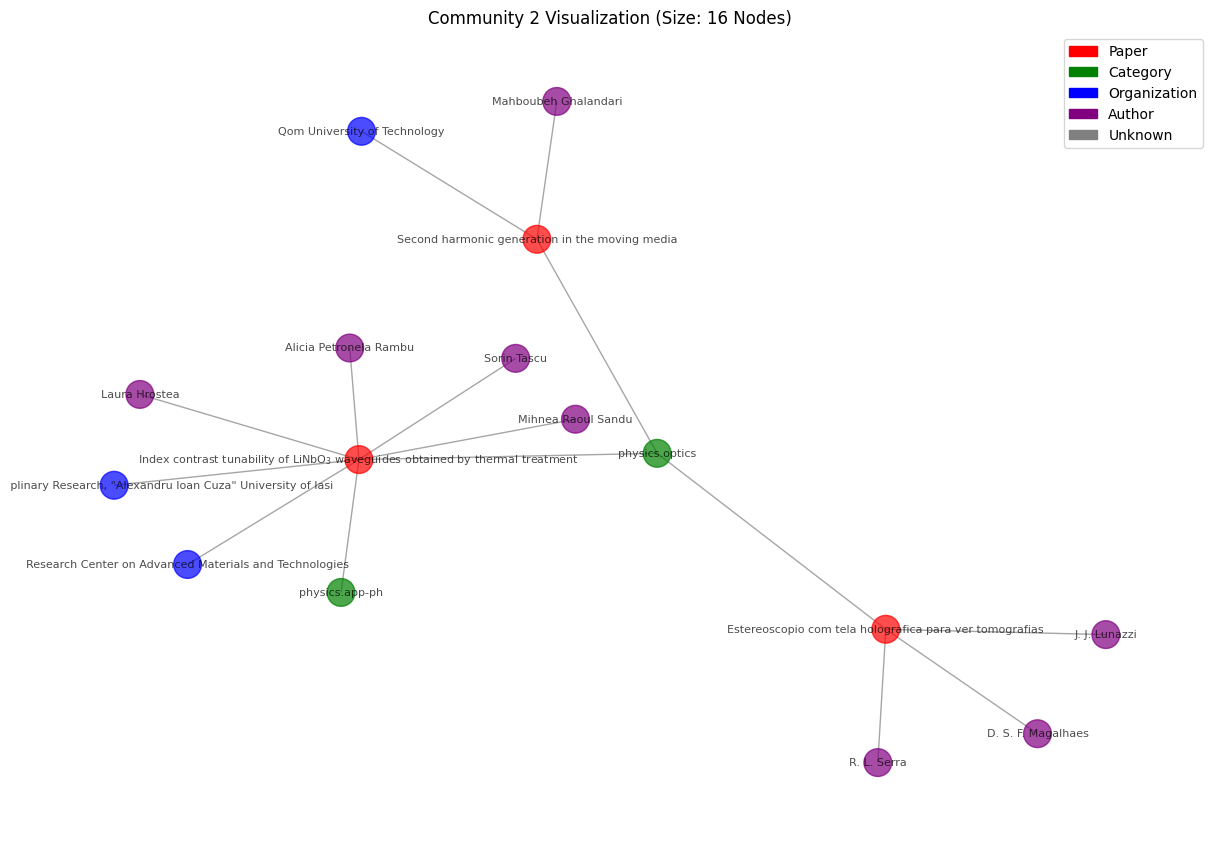

In [28]:
# Visualize only Community 2 with more details
if len(largest_components) > 1:
    subG = G.subgraph(largest_components[1])
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(subG, seed=42)

    # Assign colors based on node type
    node_colors = []
    labels = {}
    for node in subG.nodes():
        if node in paper_mapping:
            node_type = "Paper"
            node_colors.append("red")
        elif node in category_mapping:
            node_type = "Category"
            node_colors.append("green")
        elif node in organization_mapping:
            node_type = "Organization"
            node_colors.append("blue")
        elif node in author_mapping:
            node_type = "Author"
            node_colors.append("purple")
        else:
            node_type = "Unknown"
            node_colors.append("gray")
        labels[node] = node_name_mapping.get(node, node_type)

    nx.draw(subG, pos, with_labels=True, labels=labels, node_size=400, font_size=8,
            edge_color="gray", alpha=0.7, node_color=node_colors)

    # Create a legend
    import matplotlib.patches as mpatches
    legend_patches = [
        mpatches.Patch(color="red", label="Paper"),
        mpatches.Patch(color="green", label="Category"),
        mpatches.Patch(color="blue", label="Organization"),
        mpatches.Patch(color="purple", label="Author"),
        mpatches.Patch(color="gray", label="Unknown")
    ]
    plt.legend(handles=legend_patches, loc="upper right")
    plt.title(f"Community 2 Visualization (Size: {len(largest_components[1])} Nodes)")
    plt.show()

# Network Robustness Analysis and Scale-Freeness Analysis

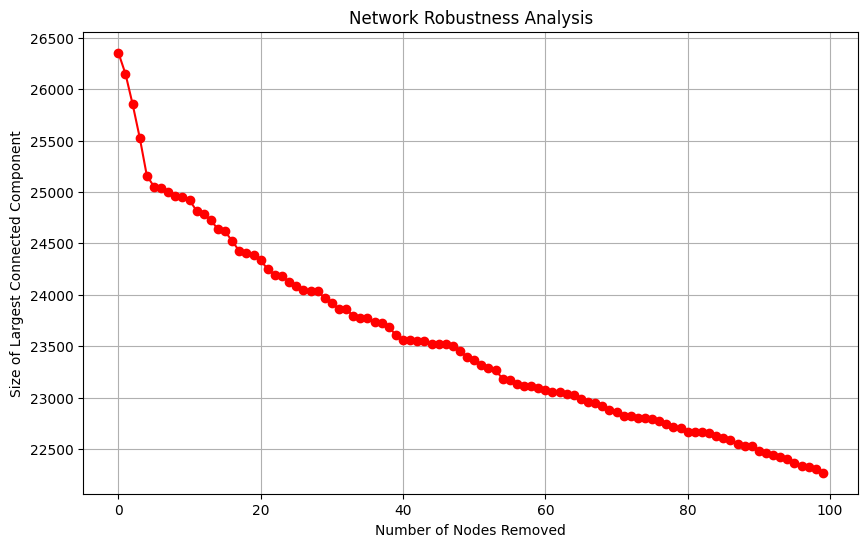

In [29]:
# Network Robustness Analysis
attack_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:100]  # Top 100 highest-degree nodes
G_copy = G.copy()
robustness = []
for node, _ in attack_nodes:
    G_copy.remove_node(node)
    largest_cc = max(nx.connected_components(G_copy), key=len, default=set())
    robustness.append(len(largest_cc))

plt.figure(figsize=(10, 6))
plt.plot(range(len(robustness)), robustness, marker='o', linestyle='-', color='r')
plt.xlabel("Number of Nodes Removed")
plt.ylabel("Size of Largest Connected Component")
plt.title("Network Robustness Analysis")
plt.grid(True)
plt.show()

This plot visualizes how the size of the largest connected component (LCC) changes as the top 100 highest-degree nodes are removed from the network.

# What Does This Mean?
* The network is robust but not invincible.

  * Removing key hubs does reduce connectivity, but it doesn't cause an immediate collapse.
  * This suggests that alternative paths exist in the structure.

* The first 10-15 nodes are highly critical.

  * These nodes have an extreme influence on network connectivity.
  * If you want to strengthen the network, these nodes should be protected or reinforced.

* Possible strategies for attack resilience:

  * Redundant connections: Add more links between less-connected nodes to create backup paths.
  * Distributed architecture: Avoid over-reliance on a few highly connected hubs.
  * Targeted monitoring: Identify and protect the most vulnerable nodes.


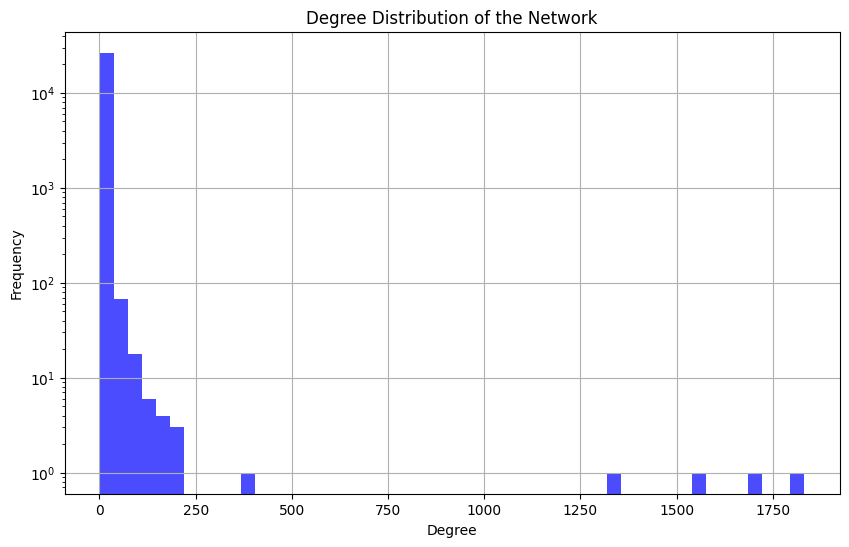

In [30]:
# Scale-Freeness Analysis (Degree Distribution)
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
plt.figure(figsize=(10, 6))
plt.hist(degree_sequence, bins=50, log=True, color='b', alpha=0.7)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution of the Network")
plt.grid(True)
plt.show()

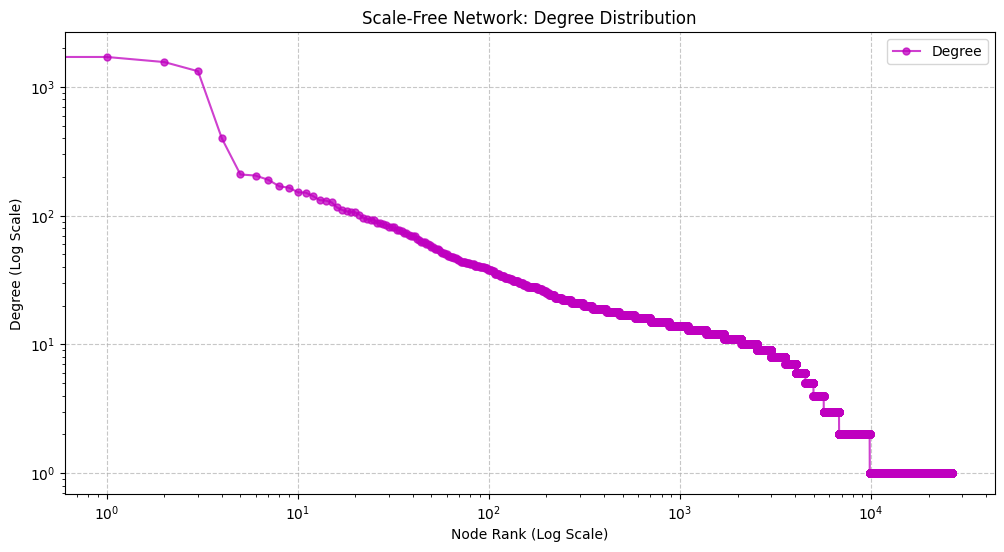

In [31]:
# Scale-Freeness Analysis (Degree Distribution) with a more fantasy plot
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
plt.figure(figsize=(12, 6))
plt.plot(degree_sequence, marker='o', linestyle='-', color='m', markersize=5, alpha=0.75, label='Degree')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Node Rank (Log Scale)")
plt.ylabel("Degree (Log Scale)")
plt.title("Scale-Free Network: Degree Distribution")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

This graph plots the degree distribution of your network on a log-log scale, which helps in identifying whether the network follows a power-law distribution (common in real-world networks like citation networks, social networks, and the internet).

# What Does This Mean?
* Your network is scale-free, meaning it behaves like a real-world complex network (e.g., citation networks, social networks, or web graphs).
* Hubs play a critical role in the network's structure. Losing them (targeted attack) would cause major disruptions.
* Resilience to random failures but vulnerable to targeted attacks (as seen in the previous robustness analysis).

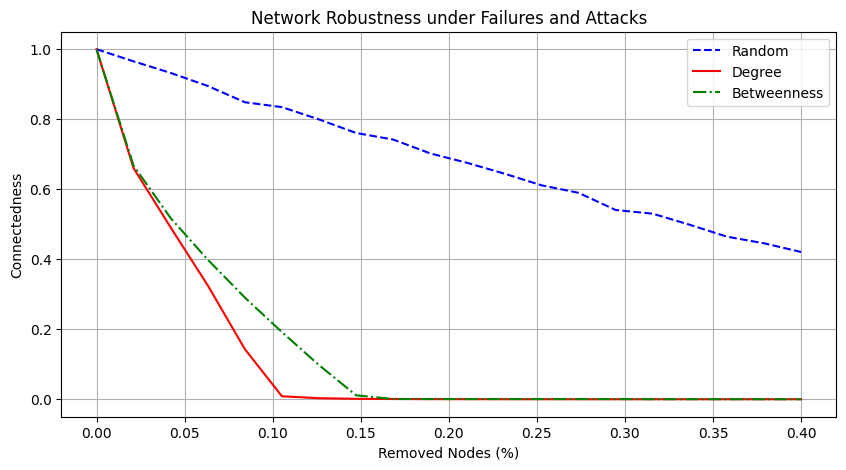

In [32]:
# Network Robustness Analysis
def remove_nodes_and_measure(G, removal_strategy, percentage_list, centrality_data=None):
    connectedness_values = []
    for percentage in percentage_list:
        G_copy = G.copy()
        num_remove = int(len(G_copy) * percentage)

        if removal_strategy == "random":
            nodes_to_remove = np.random.choice(list(G_copy.nodes), num_remove, replace=False)
        elif removal_strategy == "degree" and centrality_data:
            nodes_to_remove = sorted(centrality_data["Degree"], key=centrality_data["Degree"].get, reverse=True)[:num_remove]
        elif removal_strategy == "betweenness" and centrality_data:
            nodes_to_remove = sorted(centrality_data["Betweenness"], key=centrality_data["Betweenness"].get, reverse=True)[:num_remove]

        G_copy.remove_nodes_from(nodes_to_remove)
        largest_component = max(nx.connected_components(G_copy), key=len, default=set())
        connectedness_values.append(len(largest_component) / len(G))

    return connectedness_values

percentage_list = np.linspace(0, 0.4, 20)
random_removal = remove_nodes_and_measure(G, "random", percentage_list)
degree_removal = remove_nodes_and_measure(G, "degree", percentage_list, centrality_data)
betweenness_removal = remove_nodes_and_measure(G, "betweenness", percentage_list, centrality_data)

plt.figure(figsize=(10, 5))
plt.plot(percentage_list, random_removal, label="Random", linestyle="--", color="blue")
plt.plot(percentage_list, degree_removal, label="Degree", linestyle="-", color="red")
plt.plot(percentage_list, betweenness_removal, label="Betweenness", linestyle="-.", color="green")
plt.xlabel("Removed Nodes (%)")
plt.ylabel("Connectedness")
plt.title("Network Robustness under Failures and Attacks")
plt.legend()
plt.grid(True)
plt.show()

# Interpretation of the Network Robustness Analysis Output:

1. Blue (Random Failures):

* The network remains highly connected even when up to 40% of nodes are randomly removed.
* This suggests that the network is robust against random failures because the largest connected component still exists for a long time.

2. Red (Degree-Based Attack):

* Removing high-degree (hub) nodes quickly destroys connectivity.
* After removing just 10-15% of the highest-degree nodes, the network almost completely fragments.
* This indicates a scale-free network structure, where a small number of highly connected nodes (hubs) play a critical role in holding the network together.

3. Green (Betweenness-Based Attack):

* Removing high-betweenness nodes also causes rapid fragmentation, similar to degree-based removal.
* However, it seems slightly more gradual than degree-based removal.
* This means that central nodes in information flow are important, but hubs (degree-based) are even more crucial for connectivity.

# Key Takeaways:
* Robust against random failures (like natural removals).
* Highly vulnerable to targeted attacks on high-degree nodes, which can quickly collapse the network.
* This confirms a scale-free network, meaning that protecting or reinforcing key hubs is crucial for maintaining network integrity.

Calculating best minimal value for power law fit


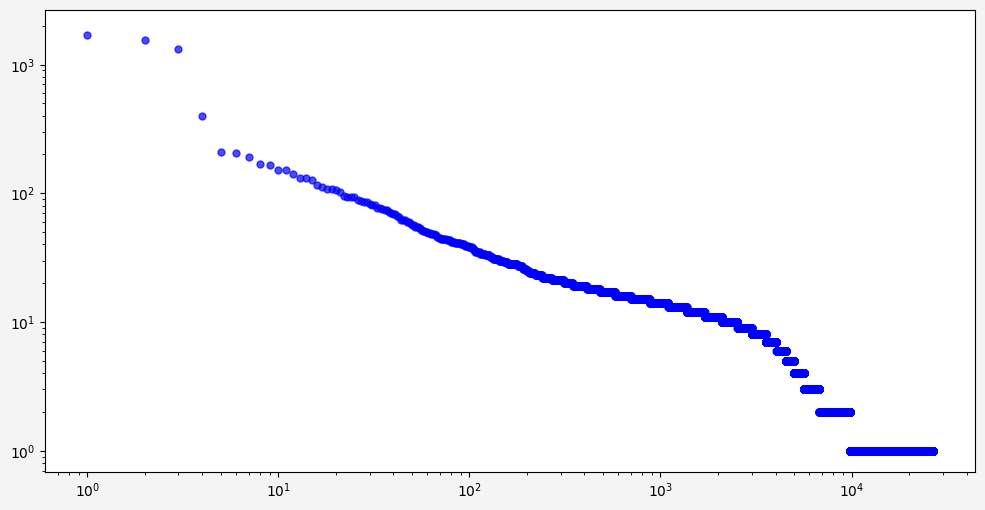

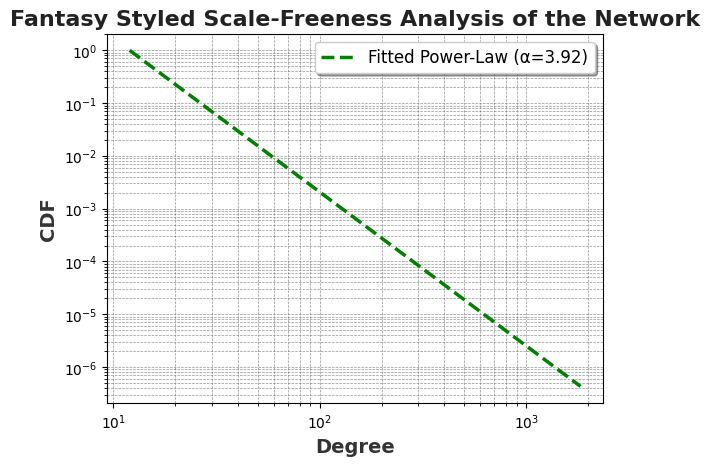

In [38]:
# Scale-Freeness Analysis using Power-Law Fitting
degree_sequence = [d for n, d in G.degree()]
fit = powerlaw.Fit(degree_sequence)
alpha = fit.alpha

# Fantasy-styled visualization
plt.figure(figsize=(12, 6), facecolor="#f4f4f4")
plt.loglog(sorted(degree_sequence, reverse=True), marker="o", linestyle="none", color="blue", markersize=5, alpha=0.7, label="Degree Distribution")
fit.power_law.plot_ccdf(color="green", linestyle="--", linewidth=2.5, label=f"Fitted Power-Law (α={alpha:.2f})")

# Styling
plt.xlabel("Degree", fontsize=14, fontweight="bold", color="#333333")
plt.ylabel("CDF", fontsize=14, fontweight="bold", color="#333333")
plt.title("Fantasy Styled Scale-Freeness Analysis of the Network", fontsize=16, fontweight="bold", color="#222222")
plt.legend(frameon=True, fancybox=True, shadow=True, fontsize=12, loc="upper right")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7, color="#666666")
plt.gca().set_facecolor("#ffffff")

# Add annotation for the most connected hub
max_degree_node = max(degree_sequence)
plt.annotate("Hub Node (Highest Degree)", xy=(1, max_degree_node), xytext=(10, max_degree_node / 2),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12, color='black')

plt.show()